In [50]:
import numpy as np
import pandas as pd
import streamlit as st
from datetime import datetime, timedelta
import os
import gspread
from google.oauth2 import service_account
from gspread_dataframe import set_with_dataframe
# from google.oauth2.service_account import Credentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from configs import *

In [51]:
#function to create api connection to google sheets
def connect_to_gs(service_account_key):
    scopes = ['https://www.googleapis.com/auth/spreadsheets']
    credentials = service_account.Credentials.from_service_account_info(service_account_key, scopes=scopes)
    gs_connection = gspread.authorize(credentials)
    return gs_connection


#create connection
gs_connection = connect_to_gs(st.secrets["gcp_service_account"])

In [3]:
#function to create/update gameweek_results table

In [4]:
#function to create/update player table

In [5]:
#function to create/update drinks table

# def submit_nomination(your_name, nominee, current_week):

#     return None

In [6]:
#function to create/update streaks table

In [7]:
#function to retrieve current game week number

In [16]:
#function to write data to google sheets
def write_google_sheets_data(gc, df, sheet_name, sheet_key):
    try:
        # Open specific sheet
        gs = gc.open_by_key(sheet_key)

        # Open specific tab within the sheet
        tab = gs.worksheet(sheet_name)

        df_values = df.values.tolist()
        gs.values_append(sheet_name, {'valueInputOption': 'RAW'}, {
                    'values': df_values})

        return None

    except gspread.exceptions.APIError as e:
        print("Error accessing Google Sheets API:", e)
        return None
    except gspread.exceptions.WorksheetNotFound as e:
        print(f"Error: Worksheet not found, please create a new tab named:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None
     

In [52]:
#function to fetch data from google sheets
def fetch_google_sheets_data(gc, sheet_name, sheet_key, columns_list):
    try:
        # Open specific sheet
        gs = gc.open_by_key(sheet_key)

        # Open specific tab within the sheet
        tab = gs.worksheet(sheet_name)

        data = tab.get_all_values()
        headers = data.pop(0)
        df = pd.DataFrame(data, columns=headers)

        for column in columns_list:
            df[column] = pd.to_numeric(df[column])

        return df

    except gspread.exceptions.APIError as e:
        print("Error accessing Google Sheets API:", e)
        return None
    except gspread.exceptions.WorksheetNotFound as e:
        print("Error: Worksheet not found:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None
    
#fetch data


In [87]:
managers_temp = ['Liam Smorfitt', 'Alex Wietzorrek', 'Hethe Brinkman']

In [88]:
red_cards =['Liam Smorfitt', 'Alex Wietzorrek',]

In [9]:
#function to return season metrics
def create_metrics(df):
    
    # Sort the DataFrame in descending order of points, then descending order of total_points then alphabetically
    df_sorted = df.sort_values(['event', 'points', 'total_points', 'player_name'], ascending=[True, False, False, True])

    # Group the DataFrame by event and get the first place finisher for each event
    first_place_df = df_sorted.groupby('event').head(1)

    # Count the occurrences of each entry in the filtered DataFrame
    first_place_player_counts = first_place_df['player_name'].value_counts()

    # Find the player with the most 1st place finishes
    most_1st_place_player = first_place_player_counts.idxmax()
    most_1st_place_count = first_place_player_counts.max()


    # Sort the DataFrame in descending order of points, then descending order of total_points then alphabetically
    df_sorted = df.sort_values(['event', 'points', 'total_points', 'player_name'], ascending=[True, False, False, False])

    # Group the DataFrame by event and get the last place finisher for each event
    last_place_df = df_sorted.groupby('event').tail(1)

    # Count the occurrences of each player in the last place DataFrame
    last_place_player_counts = last_place_df['player_name'].value_counts()

    # Find the player with the most last place finishes
    most_last_place_player = last_place_player_counts.idxmax()
    most_last_place_count = last_place_player_counts.max()


    # Group the DataFrame by player_name and calculate the sum of event_transfer_cost for each player
    player_transfer_cost = df.groupby('player_name')['event_transfers_cost'].sum()

    # Find the player with the highest total event_transfer_cost
    player_with_highest_cost = player_transfer_cost.idxmax()
    player_with_highest_cost_count = player_transfer_cost.max()/4

    # Group the DataFrame by player_name and calculate the sum of points_on_bench for each player
    player_points_on_bench = df.groupby('player_name')['points_on_bench'].sum()

    # Find the player with the highest total points_on_bench
    player_with_highest_points_on_bench = player_points_on_bench.idxmax()
    player_with_highest_points_on_bench_count = player_points_on_bench.max()


    # Find the row with the lowest points across all events
    min_score_row = df.loc[df['points'].idxmin()]

    # Extract the player_name and event for the row with the lowest score
    lowest_score_player_name = min_score_row['player_name']
    lowest_score_event = min_score_row['event']
    lowest_score_points = min_score_row['points']


    return most_1st_place_player, most_1st_place_count, most_last_place_player, most_last_place_count, player_with_highest_cost, player_with_highest_cost_count, player_with_highest_points_on_bench, player_with_highest_points_on_bench_count,lowest_score_player_name,lowest_score_event, lowest_score_points

In [ ]:
#writes nominations to googlesheets

def record_nomination(df, gc, sheet_name, sheet_key):
    try:
        # Open specific sheet
        gs = gc.open_by_key(sheet_key)

        # Open specific tab within the sheet
        tab = gs.worksheet(sheet_name)

        data = tab.get_all_values()
        headers = data.pop(0)
        df = pd.DataFrame(data, columns=headers)

        for column in columns_list:
            df[column] = pd.to_numeric(df[column])

        return df

    except gspread.exceptions.APIError as e:
        print("Error accessing Google Sheets API:", e)
        return None
    except gspread.exceptions.WorksheetNotFound as e:
        print("Error: Worksheet not found:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None
    

In [17]:
#fetch nominations data 
df = google_sheets_data(gs_connection, nominations_table, google_sheet_key, [])

In [43]:
def submit_drink(gc, df, sheet_key, nominee):
    try:
        filtered_df = df[(drinks_df["drinker_name"] == nominee) & (df["nomination_completed_date"] == "Not Completed")]
        last_record_index = filtered_df.index[-1]
        df.at[last_record_index, "nomination_completed_date"] = (datetime.now() + timedelta(hours=2)).strftime("%d/%m/%y %H:%M:%S")
    except IndexError as e:
        r = "You dont have any outstanding drinks"
        return r

    try:
        # Open specific sheet
        gs = gc.open_by_key(sheet_key)

        # Open specific tab within the sheet
        tab = gs.worksheet("drinks")

        set_with_dataframe(tab, df)

        return None

    except gspread.exceptions.APIError as e:
        print("Error accessing Google Sheets API:", e)
        return None
    except gspread.exceptions.WorksheetNotFound as e:
        print(f"Error: Worksheet not found, please create a new tab named:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None


In [ ]:
#uno reverse function, finds last incompleted record from drinks table and switches the nominator and nominee name
def uno_reverse(gc, df, sheet_key, nominee):
    try:
        filtered_df = df[(drinks_df["drinker_name"] == nominee) & (df["nomination_completed_date"] == "Not Completed")]
        last_record_index = filtered_df.index[-1]
        if 
        df.at[last_record_index, "drinker_name"] = filtered_df.nominator[last_record_index]
    except IndexError as e:
        r = "You dont have any outstanding drinks"
        return r

    try:
        # Open specific sheet
        gs = gc.open_by_key(sheet_key)

        # Open specific tab within the sheet
        tab = gs.worksheet("drinks")

        set_with_dataframe(tab, df)

        return None

    except gspread.exceptions.APIError as e:
        print("Error accessing Google Sheets API:", e)
        return None
    except gspread.exceptions.WorksheetNotFound as e:
        print(f"Error: Worksheet not found, please create a new tab named:", e)
        return None
    except Exception as e:
        print("An error occurred:", e)
        return None


In [42]:
def categories(df):
    df['number_of_drinks'] = 1
    df = df.iloc[:, [2,5,6,7]]
    # Define the conditions for the new column
    condition1 = (df['nomination_completed_date'] < df['nomination_deadline_date'])
    condition2 = (df['nomination_completed_date'] > df['nomination_deadline_date'])
    condition3 = (df['nomination_completed_date'] == 'Not Completed')

    # Apply the conditions and create the new column
    df['categories'] = 'Default Value'  # Set a default value if no conditions are met
    df.loc[condition1, 'categories'] = 'Completed'
    df.loc[condition2, 'categories'] = 'Late'
    df.loc[condition3, 'categories'] = 'Outstanding'

    return df


In [53]:
gameweek_df = fetch_google_sheets_data(gs_connection, gameweek_results_table, google_sheet_key, ['event', "total_points", 'bank', 'value'])

In [24]:
current_week = 38

In [25]:
last_10 = gameweek_df[gameweek_df.event >= current_week -10].iloc[:,[0,2,3,4]]

In [39]:
last_10['Rank'] = last_10.groupby(['event'])['total_points'].rank(ascending=False).astype(int)


In [40]:
last_10

,event,player_name,points,total_points,Rank
338,28,Marco Gouveia,51,1748,1
339,28,Divyam Dixit,42,1735,2
340,28,Ryan Shacks,60,1701,3
341,28,Connor McDonald,51,1699,4
342,28,Alex Wietzorrek,54,1690,5
...,...,...,...,...,...
476,38,Devon Jansen,24,2134,11
477,37,Liam Smorfitt,46,2053,12
478,38,Liam Smorfitt,42,2095,12
479,37,Hethe Brinkman,46,1876,13


In [46]:
current_week = 38

def build_rank_df(gameweek_df, current_week):
    last_10 = gameweek_df[gameweek_df.event >= current_week -10].iloc[:,[0,2,4]]
    last_10['Rank'] = last_10.groupby(['event'])['total_points'].rank(ascending=False).astype(int)
    return last_10

In [47]:
rank_df = build_rank_df(gameweek_df, current_week)

In [48]:
rank_df

,event,player_name,total_points,Rank
338,28,Marco Gouveia,1748,1
339,28,Divyam Dixit,1735,2
340,28,Ryan Shacks,1701,3
341,28,Connor McDonald,1699,4
342,28,Alex Wietzorrek,1690,5
...,...,...,...,...
476,38,Devon Jansen,2134,11
477,37,Liam Smorfitt,2053,12
478,38,Liam Smorfitt,2095,12
479,37,Hethe Brinkman,1876,13


In [49]:
import altair as alt

alt.Chart(rank_df).mark_line().encode(
        alt.X('event:Q'),
        alt.Y('rank:Q', sort='ascending'),
        alt.Color('player_name:N', legend=alt.Legend(
            title=None)),
    )

/Users/connormcdonald/opt/anaconda3/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [54]:
gameweek_df.head()

,event,entry,player_name,points,total_points,event_transfers_cost,points_on_bench,bank,value
0,1,1742534,Niklas Wietzorrek,68,68,0,4,0,1000
1,2,1742534,Niklas Wietzorrek,78,146,0,11,0,1002
2,3,1742534,Niklas Wietzorrek,41,187,0,11,4,1009
3,4,1742534,Niklas Wietzorrek,74,261,0,4,5,1014
4,5,1742534,Niklas Wietzorrek,70,331,0,8,1,1017


In [55]:
gameweek_df['team_value'] = (gameweek_df['bank'] + gameweek_df['value'])/10

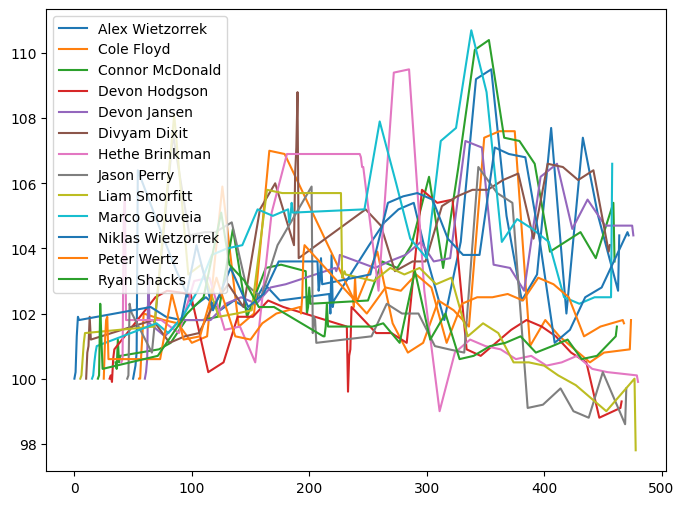

In [60]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
# gameweek_df.groupby('player_name').plot(x='event', y='team_value', kind='line', ax=ax)

for label, df in gameweek_df.groupby('player_name'):
    df.team_value.plot(x='event', y='team_value', kind='line', label=label)
plt.legend()

In [ ]:
current_week = 38

def build_rank_df(gameweek_df, current_week):
    last_10 = gameweek_df[gameweek_df.event >= current_week -10].iloc[:,[0,2,4]]
    last_10['Rank'] = last_10.groupby(['event'])['total_points'].rank(ascending=False).astype(int)
    return last_10